In [1]:
import pygmt
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
fig_dir = Path("../paper/figures")
shape_dir = Path("../data/shapefiles")
data_dir = Path("../data")
dikes = gpd.read_file(shape_dir / "dikes_cut.shp")
geology = gpd.read_file(shape_dir / "geology_cut.shp")

# Convert from SIRGAS2000 to WGS84
geology = geology.to_crs("EPSG:4326")
dikes = dikes.to_crs("EPSG:4326")

In [4]:
# Define the study area
region = [
    np.float64(-42.639999),
    np.float64(-41.900009),
    np.float64(-22.599991),
    np.float64(-22.000015),
]
bbox = box(*region)

In [5]:
def categorize_lithotypes(sigla):
    if sigla.startswith(
        tuple(["PP3rl", "NP3bp"])
    ):  # PP3rl --> Granitoides de Arco Magmático Orosiniano / NP3bp --> Paragnaisses
        return "CBT"  # Cabo Frio Domain
    elif sigla.startswith(
        tuple(["NP12itma", "NP12iteu"])
    ):  # Bacias de Margem Passiva (paragnaisses)
        return "IG"  # Italva group
    elif sigla.startswith(tuple(["NPsf"])):  # Bacias de Margem Ativa (paragnaisses)
        return "SFG"  # São Fidelis group
    elif sigla.startswith(
        tuple(["NP23"])
    ):  # Granitoides de Arco Magmático (paragnaisses)
        return "RNC"  # Rio Negro complex
    elif sigla.startswith(
        tuple(["NP3_gamma"])
    ):  # Granitoides syn-colisionais (Orogenese Rio Doce)
        return "RDO"  # Rio Doce orogeny
    elif sigla.startswith(
        tuple(["C_cortado_4O1"])
    ):  # Plutons pós-colisionais (Suíte Nova Friburgo)
        return "PCP"  # Post-collisional plutons
    elif sigla.startswith(tuple(["Q"])):  # Depósitos Quaternários
        return "Q"
    elif sigla.startswith("K2"):
        return "K2"  # Alkaline intrusions
    else:
        return "IG"


geology["category"] = geology["SIGLA_UNID"].apply(categorize_lithotypes)

In [6]:
topography = pygmt.datasets.load_earth_relief(resolution="01s", region=region)
topography = topography.rename({"lon": "longitude", "lat": "latitude"})

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
brazil = world[world.name == "Brazil"]

In [7]:
data = pd.read_csv(data_dir / "rio-de-janeiro-magnetic.csv")
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number  \
0 -42.639984 -22.290527                  -16.56      151.49         2800   
1 -42.639969 -22.291397                  -43.47      162.46         2800   
2 -42.639954 -22.292267                  -65.38      170.69         2800   
3 -42.639938 -22.293152                  -74.29      173.43         2800   
4 -42.639923 -22.294022                  -67.20      170.08         2800   

      easting_m    northing_m  deriv_up  deriv_east  deriv_north  
0 -4.393928e+06 -2.342215e+06  0.159488    0.045283    -0.096695  
1 -4.393926e+06 -2.342311e+06  0.118291    0.053503    -0.125651  
2 -4.393925e+06 -2.342407e+06  0.065451    0.062132    -0.143214  
3 -4.393923e+06 -2.342505e+06  0.003259    0.071041    -0.146666  
4 -4.393922e+06 -2.342602e+06 -0.063629    0.079413    -0.132554

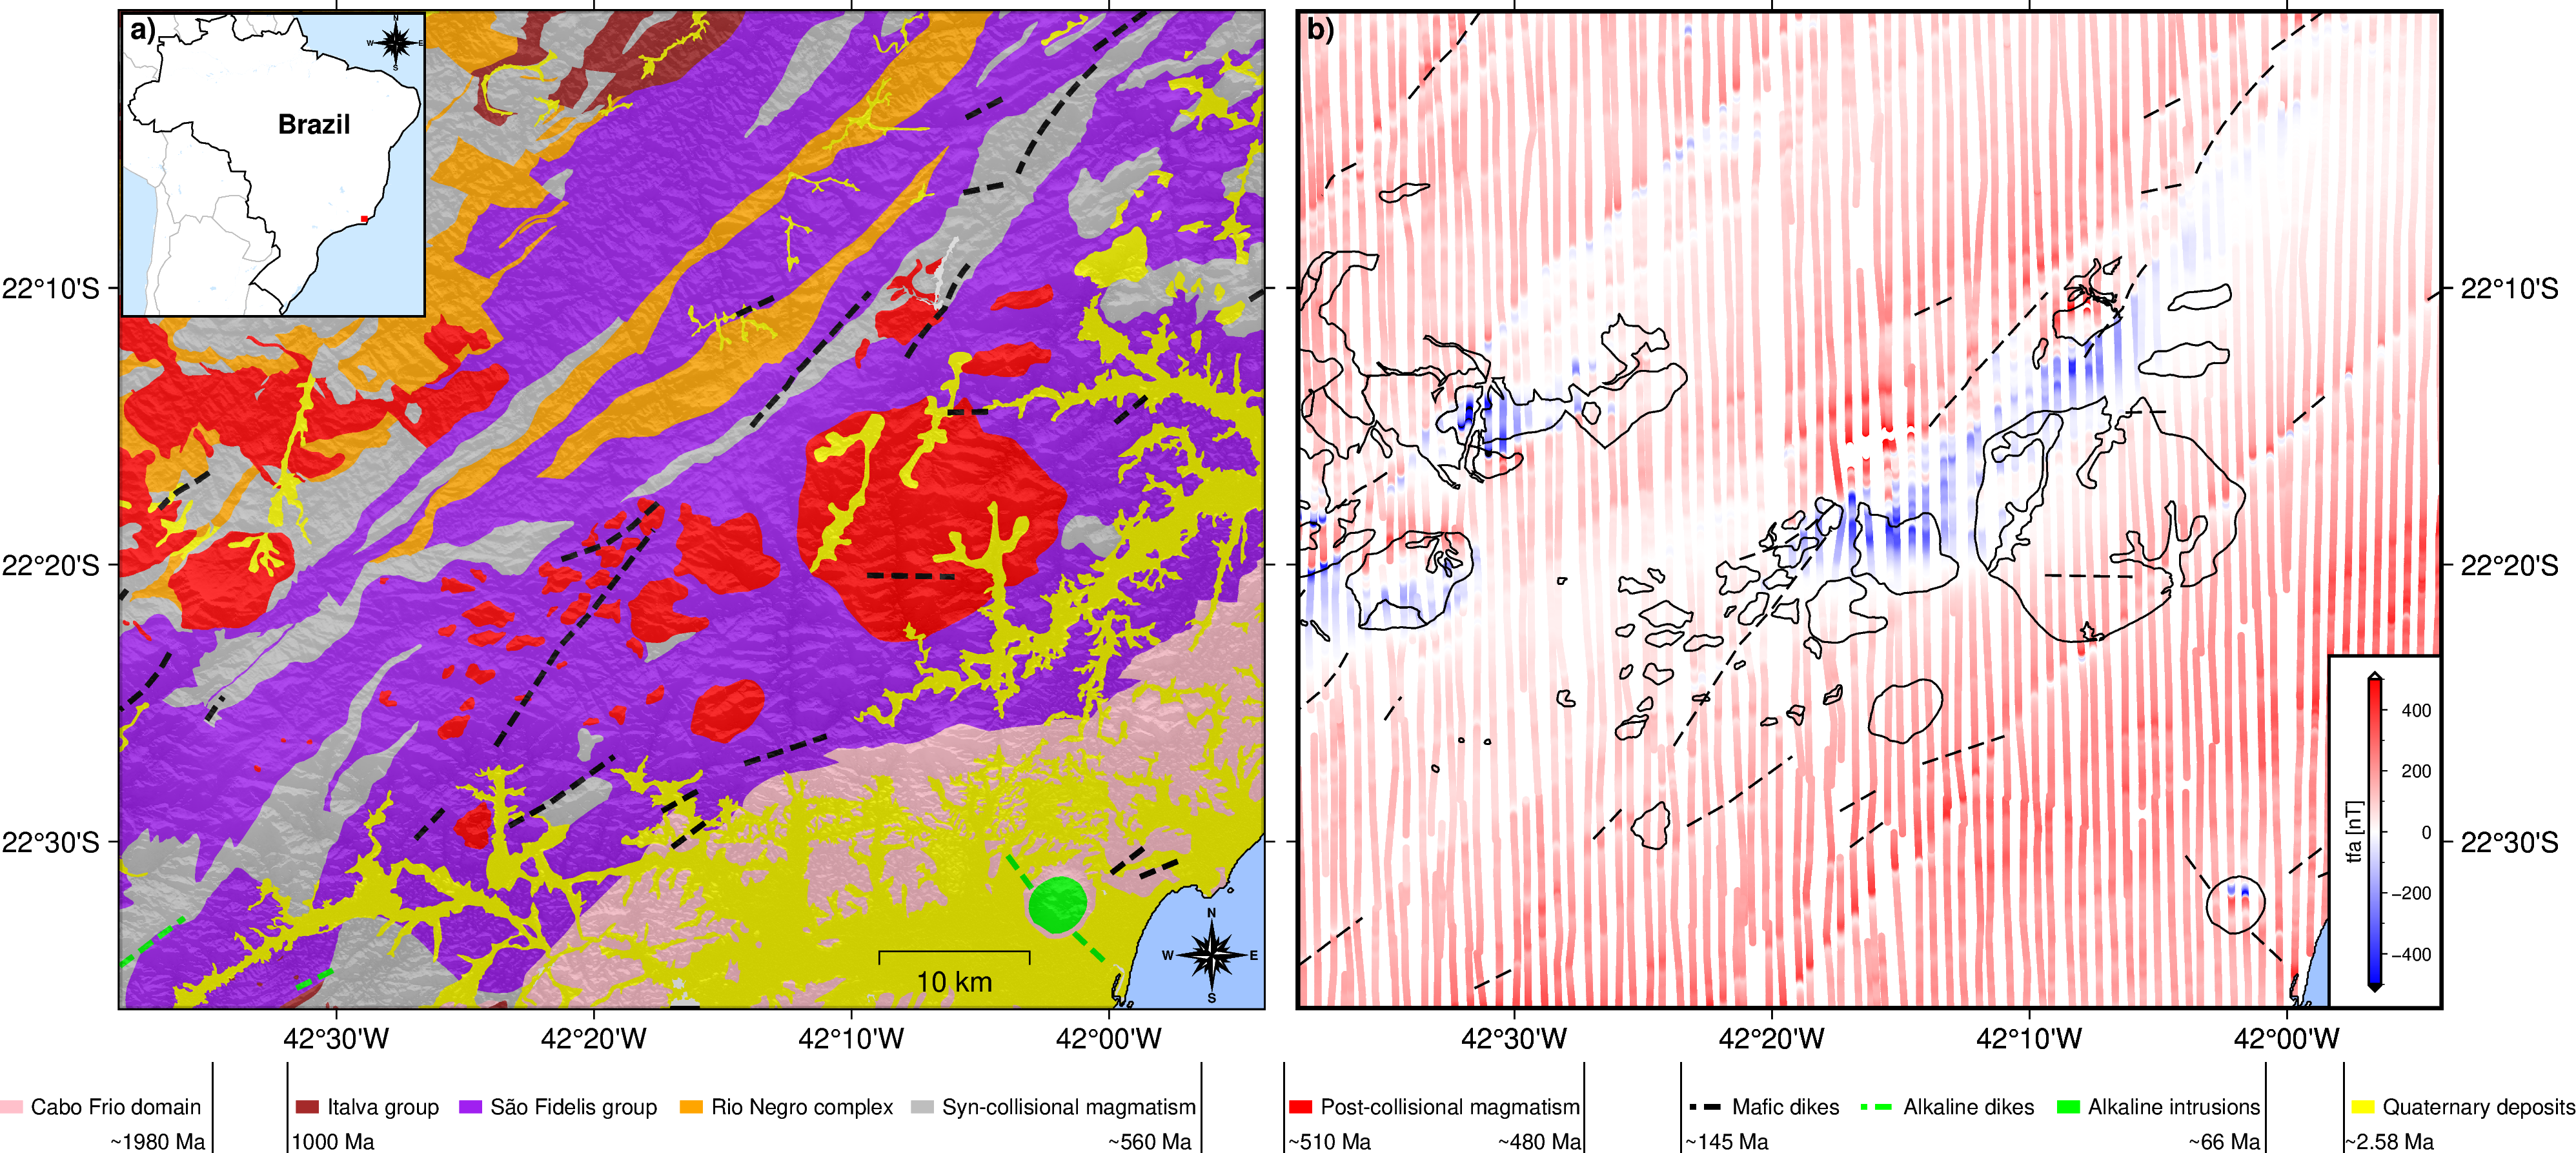

In [9]:
# Criar a figura PyGMT
fig = pygmt.Figure()
# Criar os subplots: 1 linha e 2 colunas
with fig.subplot(nrows=1, ncols=2, figsize=("30c", "15c")):

    # Primeiro subplot: Mapa com geologia e intrusões
    with fig.set_panel(panel=0):  # Primeiro subplot
        pygmt.config(MAP_FRAME_TYPE="plain", MAP_GRID_PEN_PRIMARY=0.5)
        frame = ["WSne", "xa", "ya"]
        fig.basemap(region=region, projection="M15c", frame=frame)

        # Plotando Cabo Frio terrane
        pos = -7.5
        category, color, label = "CBT", "pink", "Cabo Frio domain"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")
        pos = -7.0
        diff = 3.0
        # Plotando Paragneisses (Italva group)
        pos += diff
        category, color, label = "IG", "brown", "Italva group"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 2.5
        # Plotando Paragneisses (São Fidelis group)
        pos += diff
        category, color, label = "SFG", "purple", "São Fidelis group"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 3.0
        # Plotando Orthognaisses (Rio Negro complex)
        pos += diff
        category, color, label = "RNC", "orange", "Rio Negro complex"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 3.5
        # Plotando Syn-collisional magmatism
        pos += diff
        category, color, label = "RDO", "gray", "Syn-collisional magmatism"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 5.0
        # Plotando Post-collisional magmatism
        pos += diff
        category, color, label = "PCP", "red", "Post-collisional magmatism"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 9.5
        # Plotando Alkaline intrusions
        pos += diff
        category, color, label = "K2", "green", "Alkaline intrusions"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 4
        # Plotando Quaternary sediments
        pos += diff
        category, color, label = "Q", "yellow", "Quaternary deposits"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = -9.2
        # Plotando o dique da Serra do Mar
        pos += diff
        category, color, label = "Rocha Básica", "black", "Mafic dikes"
        file = dikes[dikes["CLASSE_DIQ"] == category]
        file = file[file.geometry.notnull()]  # Certifica-se de que há geometria válida
        fig.plot(data=file, pen=f"2p,{color},6_3:0p", projection="M15c", label=label)
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 2.4
        # Plotando os diques Alcalinos
        pos += diff
        category, color, label = "Rocha alcalina", "green", "Alkaline dikes"
        file = dikes[dikes["CLASSE_DIQ"] == category]
        file = file[file.geometry.notnull()]  # Certifica-se de que há geometria válida
        fig.plot(data=file, pen=f"2p,{color},6_3:0p", projection="M15c", label=label)
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        # # Adicionar relevo
        fig.grdimage(
            topography,
            projection="M15c",
            cmap="gray",
            frame=frame,
            shading="+a-345",
            transparency=80,
        )
        # Adicionar a cor do oceano
        fig.coast(
            shorelines="1/0.5",
            water="#A0C4FF",
            map_scale="g-42.1/-22.57+w10k",
            projection="M15c",
        )
        fig.basemap(rose="jBR+w0.85c+f3+l", projection="M15c")
        with fig.inset(position="jTL+w4.0c+o0.01c/0.01c", margin=0):

            fig.basemap(region=[-75, -34, -34, 5], frame=True)

            colfill = "white"
            fig.coast(
                region=[-75, -34, -34, 5],
                land="white",
                resolution="h",
                frame=["WSne", "xa", "ya"],  #'a',
                water="#CDE9FF",  # "#A0C4FF"
                # projection="M15c"
            )

            fig.plot(data=world, pen="0.25p,gray")
            fig.plot(data=brazil, pen="0.5p,black")

            x = [region[0], region[1], region[1], region[0], region[0]]
            y = [region[2], region[2], region[3], region[3], region[2]]

            fig.plot(
                x=x,  # Coordenadas x do quadrado
                y=y,  # Coordenadas y do quadrado
                pen="0.2p,red",  # Define a cor e espessura da borda do quadrado
                fill="red",  # Preenchimento vazio para apenas contornar
            )

            fig.text(text="Brazil", x=-49, y=-10, font="10p,Helvetica-Bold,black")
            fig.basemap(rose="jTR+w0.5c+f3+l", frame=True)

    # fig.text(text="    ______", x=-42.555, y=-22.66, font="10p,Helvetica-Bold,black", angle=90, no_clip=True)
    # fig.text(text="~1500 Ma", x=-42.625, y=-22.67, font="8p,Helvetica,black", no_clip=True)

    fig.text(
        text="    ______",
        x=-42.58,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text="~1980 Ma", x=-42.615, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-42.530,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" 1000 Ma", x=-42.500, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.920,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~560 Ma", x=-41.955, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.865,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~510 Ma", x=-41.835, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.665,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~480 Ma", x=-41.695, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.600,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~145 Ma", x=-41.570, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.210,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text="  ~66 Ma", x=-41.240, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.158,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~2.58 Ma", x=-41.128, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="a)",
        x=-42.625,
        y=-22.01,
        font="11p,Helvetica-Bold,black",
        projection="M15c",
    )

    with fig.set_panel(panel=1):  # Segundo subplot
        frame = ["wSnE", "xa", "ya"]
        pygmt.config(MAP_FRAME_TYPE="plain")
        fig.basemap(region=region, projection="M15c", frame=frame)

        pygmt.makecpt(cmap="polar", series=[-500, 500])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            fill=data.total_field_anomaly_nT,
            cmap=True,
            style="c2.5p",
            # style="h0.15c",
            projection="M15c",
            # frame=frame,
        )

        categories = ["PCP", "K2"]
        for category in categories:
            file = geology[geology["category"] == category]
            fig.plot(data=file, pen=f"0.6p,black", projection="M15c")

        categories_dikes = ["Rocha Básica", "Rocha alcalina"]
        for category in categories_dikes:
            file = dikes[dikes["CLASSE_DIQ"] == category]
            file = file[file.geometry.notnull()]
            fig.plot(data=file, pen=f"0.8p,black,6_3:0p", projection="M15c")

        fig.coast(shorelines="1/0.5", water="#A0C4FF", projection="M15c", frame=frame)
        with pygmt.config(FONT_ANNOT="13p"):
            fig.colorbar(
                frame="af+ltfa [nT]",
                position="jBR+o0.34c/-0.85c+w4.0c+ml+e",  # Posição ajustada com label no topo
                # position="jTR+h",  # Posição ajustada com label no topo
                box="+gwhite+p1p",  # Caixa branca com borda
            )

        fig.text(
            text="b)",
            x=-42.625,
            y=-22.01,
            font="11p,Helvetica-Bold,black",
            projection="M15c",
        )

fig.savefig(fig_dir / "geological-map.png", dpi=300)
fig.show(width=1200)